In [149]:
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt


In [150]:
fs, audio = wavfile.read('ENF-WHU-Dataset_H1_001.wav')
# fs, audio = wavfile.read('/content/sample_data/001.wav')
N = len(audio)
print(N)

3861649


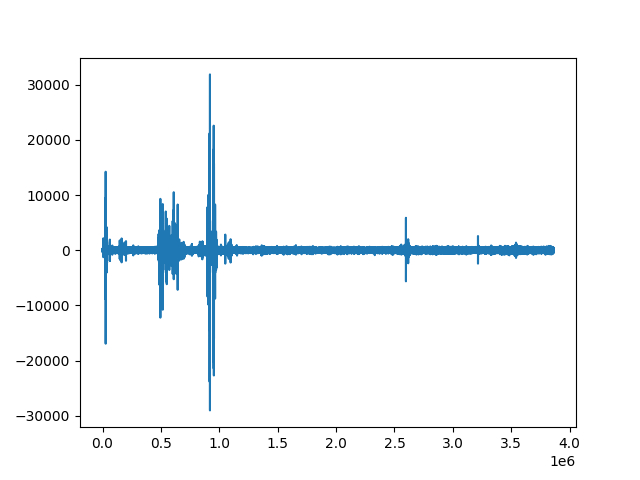

In [151]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(audio)

In [152]:
from scipy.fft import fft

sigfft = fft(audio, n=N)
abssigfft = np.abs(sigfft)
freqs = np.fft.fftfreq(N, 1 / fs)
plt.plot(freqs[:N//2], abssigfft[:N//2])
plt.xlim(95, 105)

(95.0, 105.0)

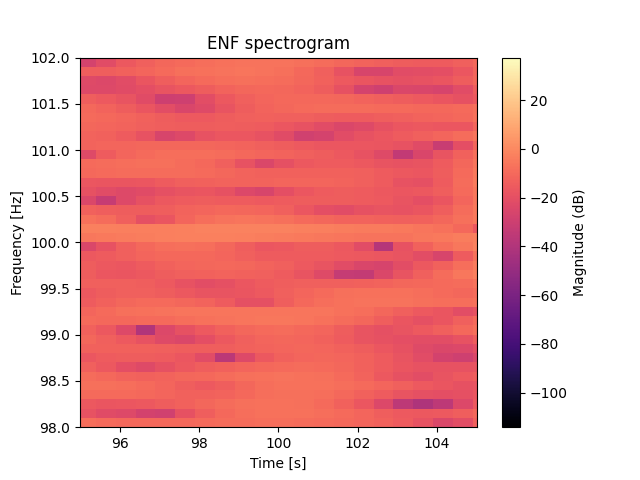

In [153]:
from scipy.signal import ShortTimeFFT, windows

w_s = fs * 10
std = w_s // 6
w = windows.gaussian(w_s, std=std)
hop = fs // 2

SFT = ShortTimeFFT(win=w, hop=hop, fs=fs, scale_to='magnitude')
Sx = SFT.spectrogram(audio)
Sx_dB = 10 * np.log10(Sx)
# Sx_dB = 10 * np.log10(np.maximum(Sx, 1e-12))

freqs = np.arange(Sx.shape[0]) * fs / w_s
times = np.arange(Sx.shape[1]) * hop / fs
# times = (np.arange(Sx.shape[1]) * hop + w_s/2) / fs

plt.imshow(
    Sx_dB,
    origin='lower',
    aspect='auto',
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    cmap='magma'
)

plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(98, 102)
plt.title('ENF spectrogram')
plt.show()

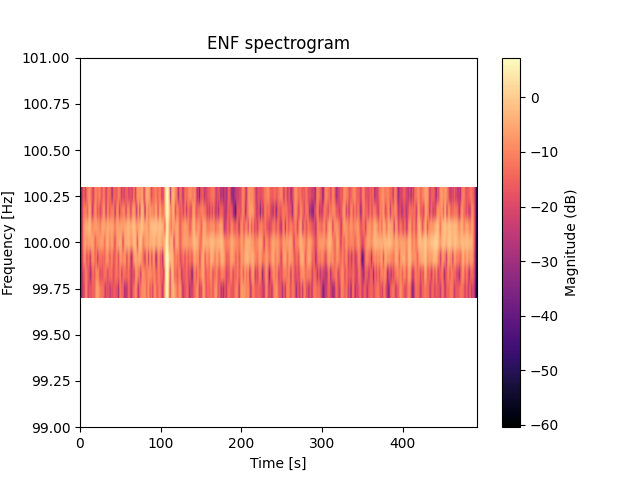

In [154]:
band_mask = (99.7 <= freqs) & (freqs <= 100.3)
Sx_dB_filtered = Sx_dB[band_mask, :]
filtered_freqs = freqs[band_mask]

plt.figure(figsize=(6.4, 4.8))
plt.imshow(
    Sx_dB_filtered,
    origin='lower',
    aspect='auto',
    extent=[times[0], times[-1], filtered_freqs[0], filtered_freqs[-1]],
    cmap='magma'
)

plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(99, 101)
plt.title('ENF spectrogram')
plt.show()

In [155]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

plt.imshow(
    Sx_dB_filtered,
    origin='lower',
    aspect='auto',
    cmap='magma',
    interpolation='bilinear'
)

ax.axis('off')
fig.canvas.draw()
width, height = fig.canvas.get_width_height() # (640, 480)
img = np.asarray(fig.canvas.buffer_rgba())
plt.close(fig)

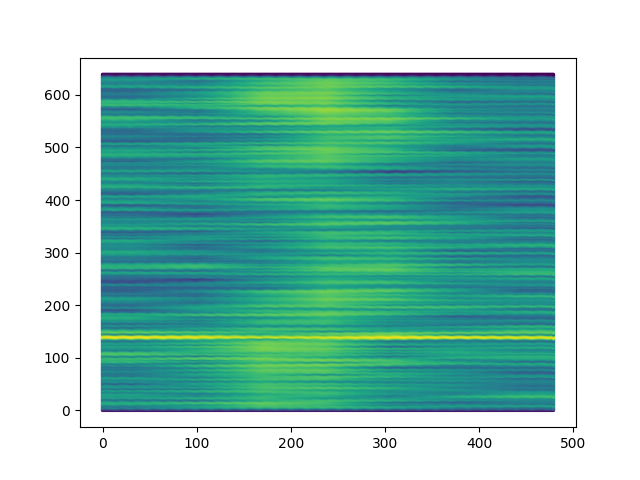

In [156]:
nx, ny, _ = img.shape
xx, yy = np.indices((nx, ny))
cords = np.column_stack((xx.ravel(), yy.ravel()))

def color_convert(c):
  r, g, b, _ = c
  lumi = int(0.2126*r + 0.7152*g + 0.0722*b)
  return lumi

img_flat = img.reshape(-1, 4)
colors = [color_convert(tuple(row)) for row in img_flat]

X = np.column_stack((cords, colors))
plt.figure(figsize=(6.4, 4.8))
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=2)
plt.show()

141.34073893229166 246


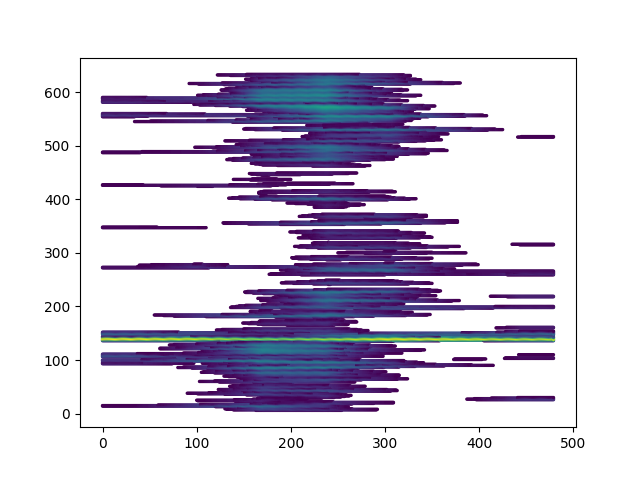

In [157]:
mean_color = X[:, 2].mean()
max_color = X[:, 2].max()
print(mean_color, max_color)

X_filtered = X.copy()
X_filtered = X_filtered[X_filtered[:, 2] > mean_color * 1.15, :]

plt.figure(figsize=(6.4, 4.8))
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=X_filtered[:, 2], s=2)
plt.show()

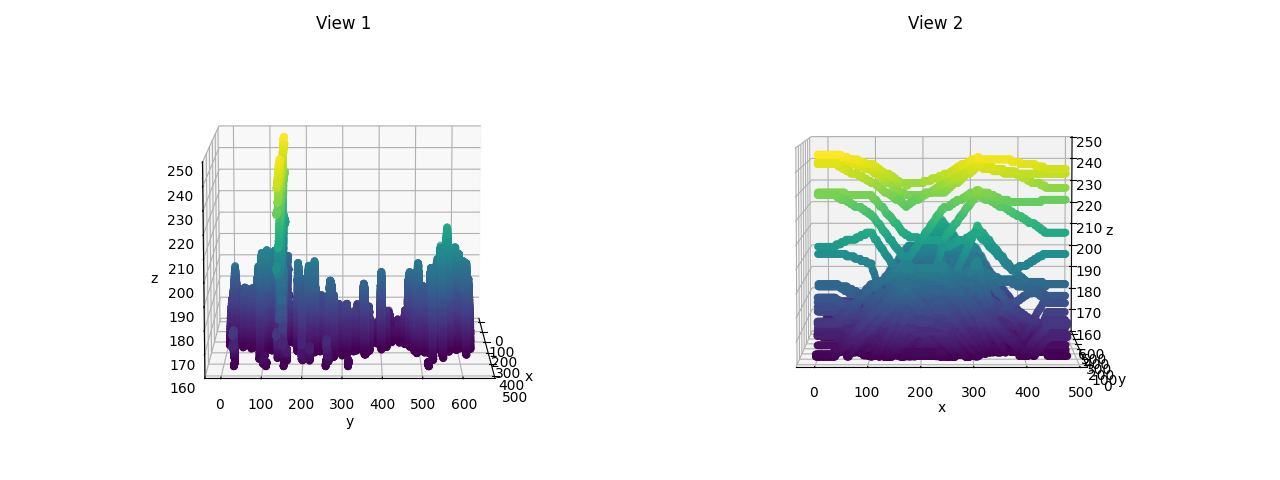

479


In [158]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(
    1, 2, figsize=(6.4*2, 4.8),
    subplot_kw={'projection': '3d'}
)

axs[0].scatter(X_filtered[:, 0], X_filtered[:, 1], X_filtered[:, 2], c=X_filtered[:, 2])
axs[0].view_init(elev=10, azim=360)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_zlabel('z')
axs[0].set_zlim((160, 250))
axs[0].set_title('View 1')

axs[1].scatter(X_filtered[:, 0], X_filtered[:, 1], X_filtered[:, 2], c=X_filtered[:, 2])
axs[1].view_init(elev=5, azim=270)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_zlabel('z')
axs[1].set_zlim((160, 250))
axs[1].set_title('View 2')

plt.tight_layout()
plt.show()


print(np.max(X_filtered[:, 0]))

In [159]:
plt.close('all')

def remove_outliers(data, axis, outlier_axis=2):
  min = np.min(data[:, axis])
  max = np.max(data[:, axis])
  sums = 0
  for v in range(min, max+1):
    line_mask = data[:, axis] == v
    if np.sum(line_mask) > 0:
      q1, q3 = np.percentile(data[line_mask, outlier_axis], [25, 75])
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr
      outliers_mask = line_mask & ((data[:, outlier_axis] < lower_bound) | (data[:, outlier_axis] > upper_bound))
      # outliers_mask = line_mask & (data[:, 2] > upper_bound)
      sums += np.sum(outliers_mask)
      data = data[outliers_mask == False]

  print(f'Removed: {sums}')
  return data


X_cleaned = X_filtered.copy()
for i in range(5):
  X_cleaned = remove_outliers(X_cleaned, 0, 2)
  X_cleaned = remove_outliers(X_cleaned, 1, 2)
  X_cleaned = remove_outliers(X_cleaned, 1, 0)

plt.close('all')


Removed: 2652
Removed: 224
Removed: 147
Removed: 596
Removed: 187
Removed: 0
Removed: 227
Removed: 42
Removed: 21
Removed: 108
Removed: 10
Removed: 57
Removed: 23
Removed: 14
Removed: 1


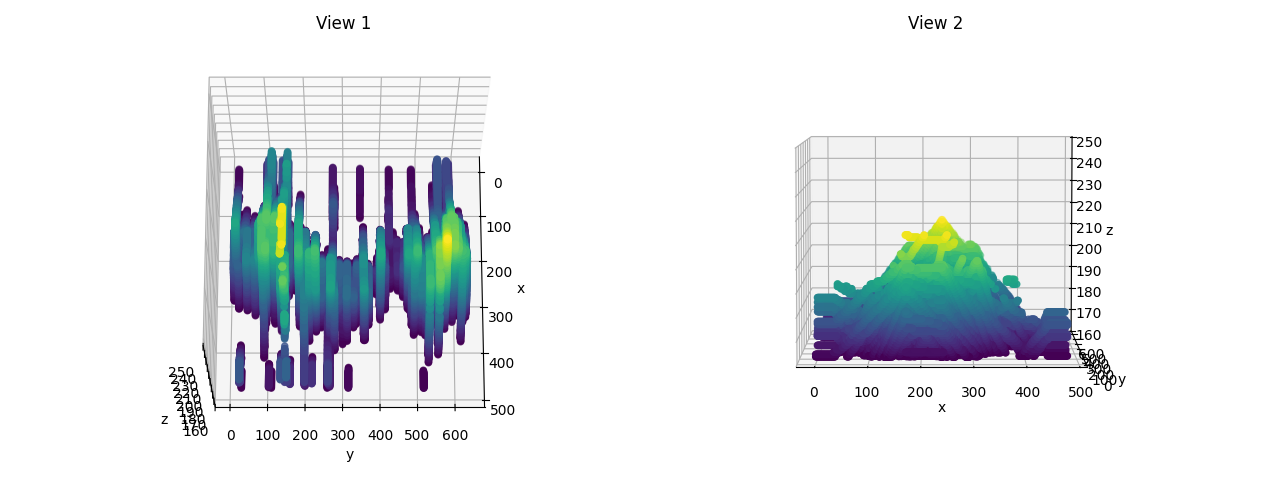

In [160]:

fig, axs = plt.subplots(
    1, 2, figsize=(6.4*2, 4.8),
    subplot_kw={'projection': '3d'}
)

axs[0].scatter(X_cleaned[:, 0], X_cleaned[:, 1], X_cleaned[:, 2], c=X_cleaned[:, 2])
axs[0].view_init(elev=70, azim=360)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_zlabel('z')
axs[0].set_zlim((160, 250))
axs[0].set_title('View 1')

axs[1].scatter(X_cleaned[:, 0], X_cleaned[:, 1], X_cleaned[:, 2], c=X_cleaned[:, 2])
axs[1].view_init(elev=5, azim=270)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_zlabel('z')
axs[1].set_zlim((160, 250))
axs[1].set_title('View 2')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'not cleaned')

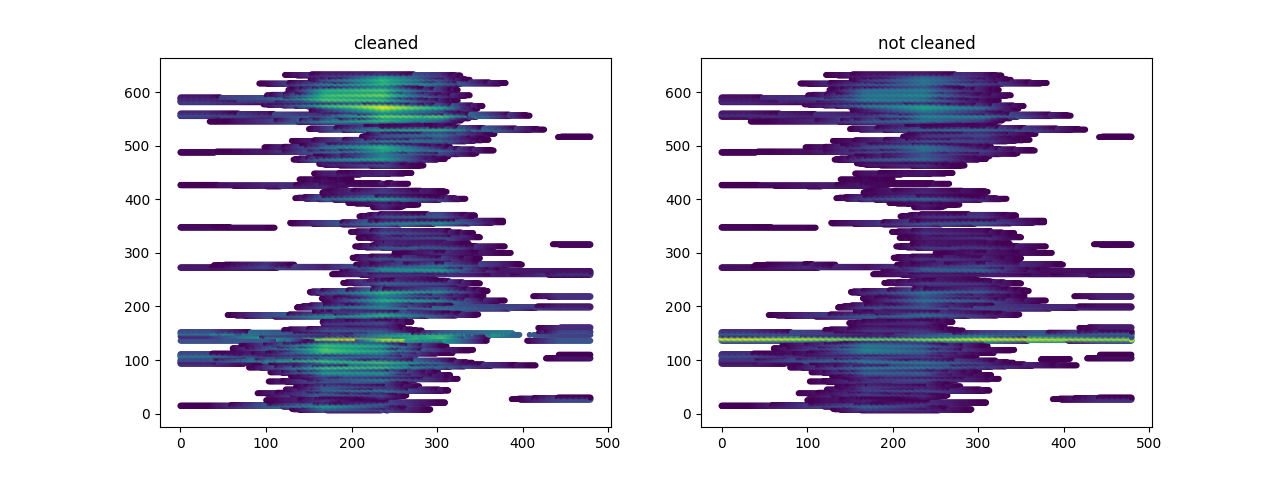

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].scatter(X_cleaned[:, 0], X_cleaned[:, 1], c=X_cleaned[:, 2], s=10)
ax[0].set_title('cleaned')
ax[1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=X_filtered[:, 2], s=10)
ax[1].set_title('not cleaned')

(0.0, 500.0)

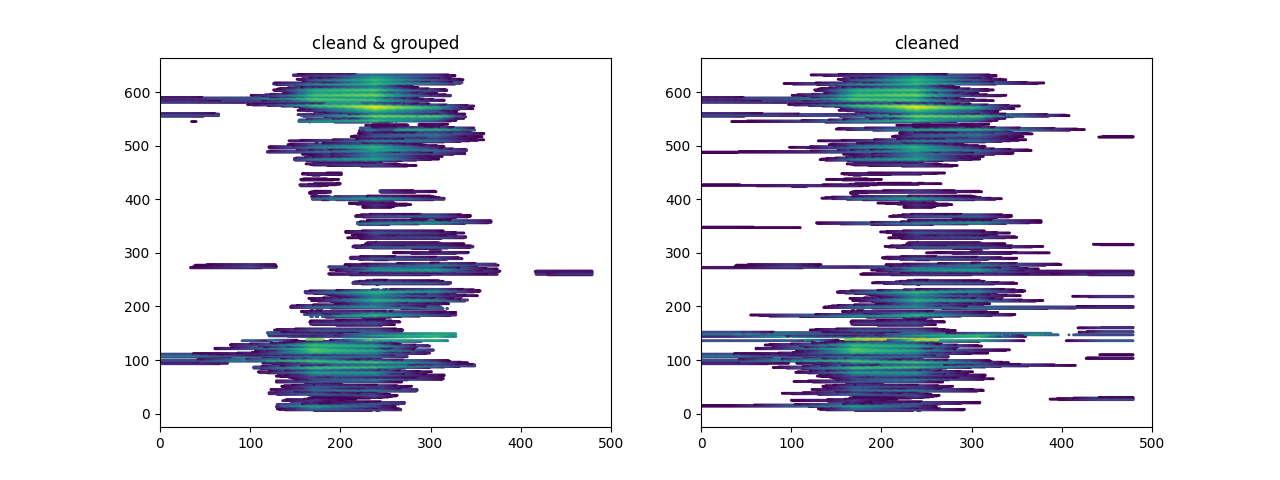

In [162]:
from sklearn.cluster import DBSCAN

def group(data, eps, min_samples):
    metric = 'euclidean'
    # model = DBSCAN(eps = 0.11, min_samples = 40, metric = metric)
    model = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    model.fit(data)

    label_mask = model.labels_ != -1
    data = data[label_mask]
    return data

X_grouped = group(X_cleaned.copy(), 11, 100)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].scatter(X_grouped[:, 0], X_grouped[:, 1], c=X_grouped[:, 2], s=1)
ax[0].set_title('cleand & grouped')
ax[0].set_xlim(0, 500)
ax[1].scatter(X_cleaned[:, 0], X_cleaned[:, 1], c=X_cleaned[:, 2], s=1)
ax[1].set_title('cleaned')
ax[1].set_xlim(0, 500)


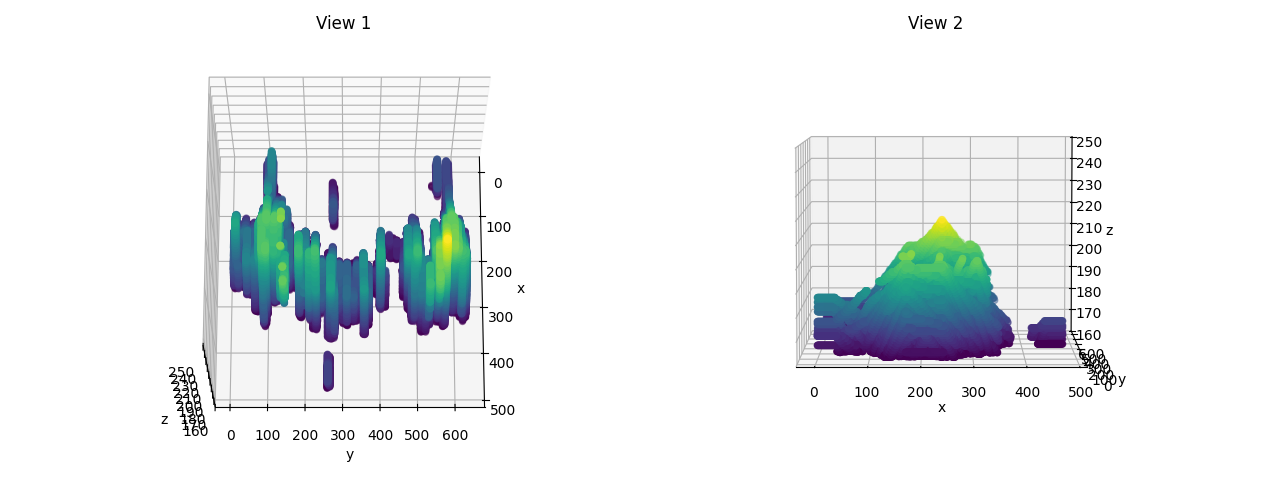

In [165]:

fig, axs = plt.subplots(
    1, 2, figsize=(6.4*2, 4.8),
    subplot_kw={'projection': '3d'}
)

axs[0].scatter(X_grouped[:, 0], X_grouped[:, 1], X_grouped[:, 2], c=X_grouped[:, 2])
axs[0].view_init(elev=70, azim=360)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_zlabel('z')
axs[0].set_zlim((160, 250))
axs[0].set_title('View 1')

axs[1].scatter(X_grouped[:, 0], X_grouped[:, 1], X_grouped[:, 2], c=X_grouped[:, 2])
axs[1].view_init(elev=5, azim=270)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_zlabel('z')
axs[1].set_zlim((160, 250))
axs[1].set_title('View 2')

plt.tight_layout()
plt.show()

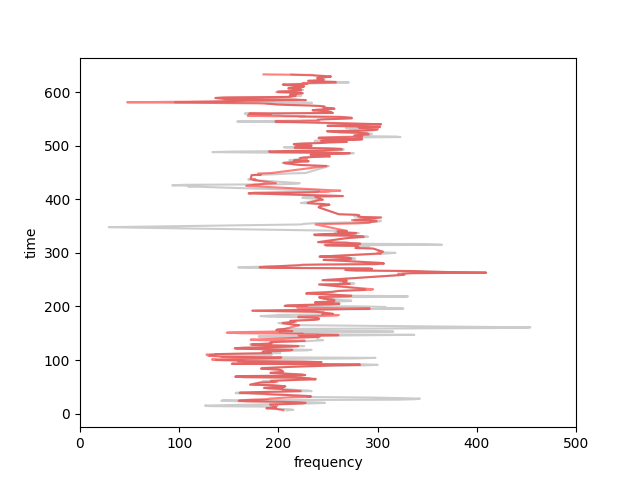

In [163]:
time_f, indices_f = np.unique(X_filtered[:, 1], return_inverse = True)
time_g, indices_g = np.unique(X_grouped[:, 1], return_inverse = True)

means_f = np.bincount(indices_f, weights=X_filtered[:, 0]) / np.bincount(indices_f)
means_g = np.bincount(indices_g, weights=X_grouped[:, 0]) / np.bincount(indices_g)

medians_f = np.array([
    np.median(X_filtered[indices_f == i, 0])
    for i in range(len(time_f))
])

medians_g = np.array([
    np.median(X_grouped[indices_g == i, 0])
    for i in range(len(time_g))
])

enf_f = np.column_stack((time_f, means_f))
enf_g = np.column_stack((time_g, means_g))

plt.figure(figsize=(6.4, 4.8))
plt.plot(enf_f[:, 1], enf_f[:, 0], c='black', alpha=0.2)
plt.plot(enf_g[:, 1], enf_g[:, 0], c='red', alpha=0.5)

enf_f = np.column_stack((time_f, medians_f))
enf_g = np.column_stack((time_g, medians_g))

# plt.plot(enf_g[:, 1], enf_g[:, 0], c='green', alpha=0.5)
plt.xlim(0, 500)
plt.ylabel('time')
plt.xlabel('frequency')
plt.show()

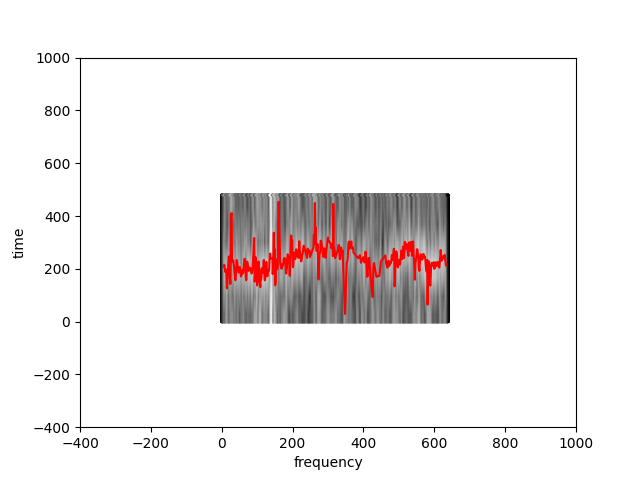

In [168]:
plt.figure()
plt.scatter(X[:, 1], X[:, 0], c=X[:, 2], cmap='grey', s=2)
# plt.plot((enf_f[:, 0] + enf_g[:, 0]) / 2, (enf_f[:, 1] + enf_g[:, 1]) / 2, c='red')
plt.plot(enf_f[:, 0], enf_f[:, 1], c='red')
plt.ylabel('time')
plt.xlabel('frequency')
plt.xlim(-400, 1000)
plt.ylim(-400, 1000)
plt.xticks(rotation=0)
plt.show()